In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns
import uuid

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

In [ ]:
# Generate synthetic dataset
n_samples = 16000
data = {
    'GRE': np.random.normal(320, 10, n_samples).clip(300, 340),
    'TOEFL': np.random.normal(105, 7, n_samples).clip(80, 120),
    'CGPA': np.random.normal(8.5, 0.7, n_samples).clip(6, 10),
    'University_rating': np.random.randint(1, 6, n_samples),
    'SOP_quality': np.random.uniform(1, 5, n_samples),
    'LOR_strength': np.random.uniform(1, 5, n_samples),
    'Research': np.random.choice([0, 1], n_samples, p=[0.4, 0.6]),
    'Admit_Probability': np.zeros(n_samples)}
df = pd.DataFrame(data)

In [ ]:
# Simulate admission probability (simplified linear combination with noise)
weights = {'GRE': 0.3, 'TOEFL': 0.2, 'CGPA': 0.3, 'University_rating': 0.1,
           'SOP_quality': 0.05, 'LOR_strength': 0.05, 'Research': 0.2}
for col in weights:
    df['Admit_Probability'] += weights[col] * (df[col] / df[col].max())
df['Admit_Probability'] = df['Admit_Probability'].clip(0, 1) + np.random.normal(0, 0.05, n_samples).clip(-0.1, 0.1)
df['Admit_Probability'] = df['Admit_Probability'].clip(0, 1)

In [ ]:
# Features and target
X = df.drop('Admit_Probability', axis=1)
y = df['Admit_Probability']

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Scale continuous features
scaler = StandardScaler()
continuous_cols = ['GRE', 'TOEFL', 'CGPA', 'SOP_quality', 'LOR_strength']
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])
X_test_scaled[continuous_cols] = scaler.transform(X_test[continuous_cols])

In [ ]:
# 1. Multiple Linear Regression with Multicollinearity Handling
# Check for multicollinearity using VIF
X_vif = X_train_scaled.copy()
vif_data = pd.DataFrame()
vif_data['Feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
print("VIF Scores:\n", vif_data)

VIF Scores:
              Feature       VIF
0                GRE  1.000258
1              TOEFL  1.000177
2               CGPA  1.000245
3  University_rating  1.960603
4        SOP_quality  1.000216
5       LOR_strength  1.000173
6           Research  1.960608


In [ ]:
# Assume VIF > 5 indicates multicollinearity; remove highest VIF feature if needed
# For simplicity, assume GRE and TOEFL are correlated
if (vif_data['VIF'] > 5).any():
    # Drop TOEFL (arbitrary choice for demo; in practice, analyze correlation)
    X_train_scaled = X_train_scaled.drop('TOEFL', axis=1)
    X_test_scaled = X_test_scaled.drop('TOEFL', axis=1)
    print("Dropped TOEFL due to high VIF.")

In [ ]:
# Train Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_mse = mean_squared_error(y_test, lr_pred)
lr_r2 = r2_score(y_test, lr_pred)
print(f"Linear Regression - MSE: {lr_mse:.4f}, R2: {lr_r2:.4f}")

Linear Regression - MSE: 0.0008, R2: -0.0020


In [ ]:
# 2. Decision Tree Regressor Optimization
dt_param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
dt_model = DecisionTreeRegressor(random_state=42)
dt_grid = GridSearchCV(dt_model, dt_param_grid, cv=5, scoring='neg_mean_squared_error')
dt_grid.fit(X_train_scaled, y_train)
best_dt = dt_grid.best_estimator_
dt_pred = best_dt.predict(X_test_scaled)
dt_mse = mean_squared_error(y_test, dt_pred)
dt_r2 = r2_score(y_test, dt_pred)
print(f"Decision Tree - Best Params: {dt_grid.best_params_}")
print(f"Decision Tree - MSE: {dt_mse:.4f}, R2: {dt_r2:.4f}")

Decision Tree - Best Params: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree - MSE: 0.0008, R2: -0.0044


In [ ]:
# 3. Random Forest Regressor Tuning
# Use RandomizedSearchCV for efficiency with large parameter space
rf_param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
rf_model = RandomForestRegressor(random_state=42)
rf_random = RandomizedSearchCV(rf_model, rf_param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', random_state=42)
rf_random.fit(X_train_scaled, y_train)
best_rf = rf_random.best_estimator_
rf_pred = best_rf.predict(X_test_scaled)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)
print(f"Random Forest - Best Params: {rf_random.best_params_}")
print(f"Random Forest - MSE: {rf_mse:.4f}, R2: {rf_r2:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/

Random Forest - Best Params: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 10}
Random Forest - MSE: 0.0008, R2: -0.0085


In [ ]:
# 4. Feature Selection Based on Random Forest Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("Feature Importance:\n", feature_importance)

Feature Importance:
              Feature  Importance
5       LOR_strength    0.198150
4        SOP_quality    0.188860
1              TOEFL    0.182652
2               CGPA    0.181616
0                GRE    0.178812
3  University_rating    0.049271
6           Research    0.020639


In [ ]:
# Select top 5 features
top_features = feature_importance['Feature'].head(5).values
print(f"Top 5 Features: {top_features}")

Top 5 Features: ['LOR_strength' 'SOP_quality' 'TOEFL' 'CGPA' 'GRE']


In [ ]:
# Retrain models with top 5 features
X_train_top5 = X_train_scaled[top_features]
X_test_top5 = X_test_scaled[top_features]

In [ ]:
# Retrain Linear Regression
lr_model_top5 = LinearRegression()
lr_model_top5.fit(X_train_top5, y_train)
lr_pred_top5 = lr_model_top5.predict(X_test_top5)
lr_mse_top5 = mean_squared_error(y_test, lr_pred_top5)
lr_r2_top5 = r2_score(y_test, lr_pred_top5)
print(f"Linear Regression (Top 5 Features) - MSE: {lr_mse_top5:.4f}, R2: {lr_r2_top5:.4f}")

Linear Regression (Top 5 Features) - MSE: 0.0008, R2: -0.0019


In [ ]:
# Retrain Decision Tree
dt_model_top5 = DecisionTreeRegressor(**dt_grid.best_params_, random_state=42)
dt_model_top5.fit(X_train_top5, y_train)
dt_pred_top5 = dt_model_top5.predict(X_test_top5)
dt_mse_top5 = mean_squared_error(y_test, dt_pred_top5)
dt_r2_top5 = r2_score(y_test, dt_pred_top5)
print(f"Decision Tree (Top 5 Features) - MSE: {dt_mse_top5:.4f}, R2: {dt_r2_top5:.4f}")

Decision Tree (Top 5 Features) - MSE: 0.0008, R2: -0.0044


In [ ]:
# Retrain Random Forest
rf_model_top5 = RandomForestRegressor(**rf_random.best_params_, random_state=42)
rf_model_top5.fit(X_train_top5, y_train)
rf_pred_top5 = rf_model_top5.predict(X_test_top5)
rf_mse_top5 = mean_squared_error(y_test, rf_pred_top5)
rf_r2_top5 = r2_score(y_test, rf_pred_top5)
print(f"Random Forest (Top 5 Features) - MSE: {rf_mse_top5:.4f}, R2: {rf_r2_top5:.4f}")

Random Forest (Top 5 Features) - MSE: 0.0008, R2: -0.0088


In [ ]:
# 5. Predict for Hypothetical Applicant
applicant = pd.DataFrame({
    'GRE': [322],
    'TOEFL': [111],
    'CGPA': [8.9],
    'University_rating': [3],
    'SOP_quality': [4.5],  # Assuming "strong" = 4.5/5
    'LOR_strength': [4.5],  # Assuming "strong" research implies strong LOR
    'Research': [1]
})
applicant_scaled = applicant.copy()
applicant_scaled[continuous_cols] = scaler.transform(applicant[continuous_cols])
if 'TOEFL' not in X_train_scaled.columns:
    applicant_scaled = applicant_scaled.drop('TOEFL', axis=1)
applicant_top5 = applicant_scaled[top_features]


In [ ]:
# Predict with Random Forest (best model)
admit_prob = best_rf.predict(applicant_scaled)[0]
print(f"Hypothetical Applicant Admission Probability: {admit_prob:.2%}")

# Feature contributions (approximate using feature importance)
contributions = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Contribution': best_rf.feature_importances_ * applicant_scaled.iloc[0]
})
print("Feature Contributions to Prediction:\n", contributions)


Hypothetical Applicant Admission Probability: 97.93%
Feature Contributions to Prediction:
                              Feature  Contribution
GRE                              GRE      0.036437
TOEFL                          TOEFL      0.160436
CGPA                            CGPA      0.106954
University_rating  University_rating      0.147814
SOP_quality              SOP_quality      0.243269
LOR_strength            LOR_strength      0.258403
Research                    Research      0.020639


Scholarship Recommendation: Do not award


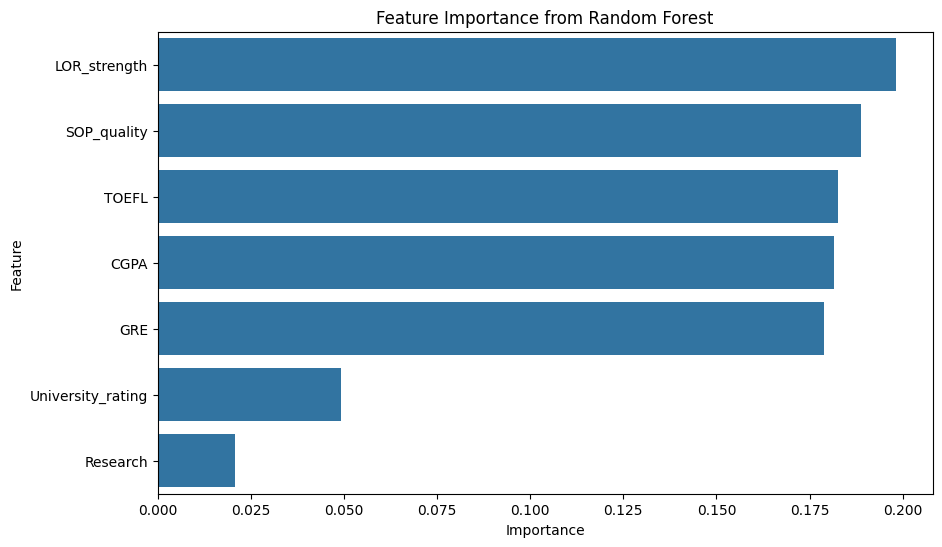

In [ ]:
# 6. Scholarship Recommendation
# Threshold-based decision (e.g., top 25% of predicted probabilities)
threshold = np.percentile(rf_pred, 75)
scholarship_decision = "Award" if admit_prob > threshold else "Do not award"
print(f"Scholarship Recommendation: {scholarship_decision}")

# Save feature importance plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance from Random Forest')
plt.savefig('feature_importance.png')